In [4]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    RSIPeriodfast = 6; RSIPeriodslow = 12
    Cortime = 6
    stopRatio = 0.03
    lot = 10000
    stdparam = 24
    fastmaperiod = 5
    slowmaperiod = 60
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    DelVol = {} #记录量是否增长
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'RSIPeriodfast',
                 'RSIPeriodslow',
                 'Cortime',
                 'stopRatio',
                 'stdparam'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'stdparam',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+4*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-4*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        Mafast = ta.MA(am15.close,self.fastmaperiod)
        Maslow = ta.MA(am15.close,self.slowmaperiod)
        diff = Mafast - Maslow
        bol = np.abs(diff)>0.1
        angle = ta.LINEARREG_ANGLE(Maslow,5)
        i = 1
        if(bol[-i]==False):
            sum1 = 0
            sum2 = 0
            sum3 = 0
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum1 = sum1+diff[-i]
                i = i+1
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum2 = sum2+diff[-i]
                i = i+1
            while(bol[-i]==False and i<len(diff)):
                i = i+1
            while(bol[-i]==True and i<len(diff)):
                sum3 = sum3+diff[-i]
                i = i+1
            if angle[-1]>-30 and (((sum1<0) and (sum1>sum2))or(np.abs(sum2)<min(np.abs(sum1),np.abs(sum3)) and sum1<0 and sum1>sum3)):
            # 做多信号
                if  (self.posDict[symbol+'_SHORT']==0)and(self.posDict[symbol+'_LONG']==0):
                    self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
                elif self.posDict[symbol+'_SHORT'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
        # 做空信号
            elif angle[-1]<30 and (((sum1>0) and (sum2>sum1)) or (np.abs(sum2)<min(sum1,sum3) and sum1>0 and sum1<sum3)):
                if (self.posDict[symbol+'_LONG']==0)and(self.posDict[symbol+'_SHORT']==0):
                    self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
                elif self.posDict[symbol+'_LONG'] > 0:
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                    self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        alpha2 = -1*ta.CORREL(np.diff(ta.LOG10(ta.MA(am60.volume,24)),1),np.diff(ta.LOG10(ta.MA((am60.high-am60.low)/(am60.close),24)),1),self.Cortime)
        alpha2mean = ta.MA(alpha2,5)
        STD = ta.STDDEV(np.diff(am60.close)/am60.close[:-1], self.stdparam)
        RSIfast = ta.RSI(am60.close,self.RSIPeriodfast)
        RSIslow = ta.RSI(am60.close,self.RSIPeriodslow)
        
        fastMa = ta.EMA(am60.close, self.fastmaperiod)
        slowMa = ta.EMA(am60.close, self.slowmaperiod)
        angle60 = ta.LINEARREG_ANGLE(slowMa,timeperiod=4)
        if (angle60[-1]>0) and(RSIfast[-1]>RSIslow[-1]) and  (alpha2mean[-1]>-0.3) and (STD[-1]<0.008) and (self.posDict[symbol+'_LONG']==0):
            if  (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            elif (self.posDict[symbol+'_SHORT'] > 0):
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        if (angle60[-1]<0) and (RSIfast[-1]<RSIslow[-1]) and (alpha2mean[-1]>-0.3) and (STD[-1]<0.008) and (self.posDict[symbol+'_SHORT']==0):
            if (self.posDict[symbol+'_LONG']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif (self.posDict[symbol+'_LONG'] > 0):
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        self.putEvent()
    
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


In [5]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x130819488>, <__main__.MultiFrameMaStrategy object at 0x12d86f588>)
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x130823a60>, <__main__.MultiFrameMaStrategy object at 0x12d86f588>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x130804e18>, <__main__.MultiFrameMaStrategy object at 0x12d86f588>)
2018-12-11 20:16:27.336846	开始回测
2018-12-11 20:16:27.336926	策略初始化
2018-12-11 20:16:27.339145	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-11 20:16:27.840370	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-11 20:16:27.843123	载入完成，数据量：11295
2018-12-11 20:16:27.843556	策略初始化完成
2018-12-11 20:16:27.843604	策略启动完成
2018-12-11 20:16:27.843695	开始回放回测数据,回测范围:[20180701 12:00,20181121 12:00)
2018-12-11 20:16:27.866025	载

Traceback (most recent call last):
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/vnpy_fxdayu-1.1.14-py3.6.egg/vnpy/trader/app/ctaStrategy/ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "/Users/yuewang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 3081, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180627070000 , 20180701110000]
[INFO] 品种EOSUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180701120000
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180630110000 , 20180701114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180701120100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180701120000
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180701120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 7.9618, 'high': 7.9785, 'low': 7.9555, 'close': 7.9666, 'date': '20180701', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 12, 0), 'volume': 76756.84999999999, 'openInterest': 0}


/Users/yuewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater


[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180630111500 , 20180701120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180701120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 7.9618, 'high': 8.0198, 'low': 7.9359, 'close': 8.0136, 'date': '20180701', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 7, 1, 12, 0), 'volume': 354895.4799999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180627080000 , 20180701120000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180701120000
2018-07-02 06:00:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG takeProfit6:45.877903	Progress: 1%    
2018-07-04 03:15:00 {'EOSUSDT:binance_LONG': 10000, 'EOSUSDT:binance_SHORT': 0}
LONG stopLoss:16:46.238678	Progress: 3%    
2018-07-09 17:00:00 {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 10000}
SHORT takeProfit
2018-07-11 08:45:00.886633	Progress: 6%     {'EOSUSDT:b

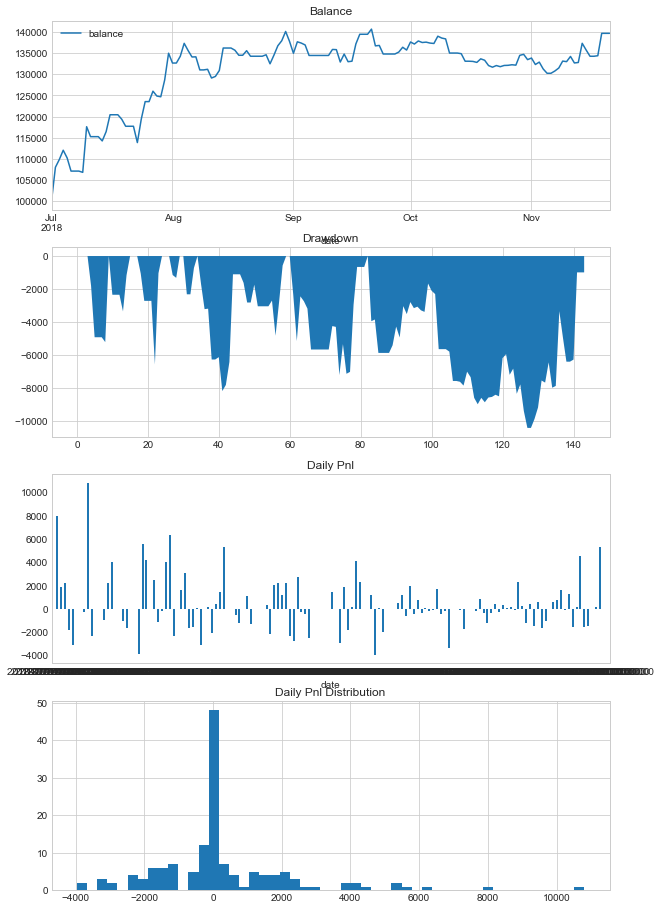

2018-12-11 20:17:07.990990	计算回测结果
2018-12-11 20:17:08.003858	------------------------------
2018-12-11 20:17:08.003993	第一笔交易：	2018-07-03 03:18:00
2018-12-11 20:17:08.004066	最后一笔交易：	2018-11-19 17:55:00
2018-12-11 20:17:08.004133	总交易次数：	62
2018-12-11 20:17:08.004298	总盈亏：	39,700.71
2018-12-11 20:17:08.004371	最大回撤: 	-9,235.68
2018-12-11 20:17:08.004541	平均每笔盈利：	640.33
2018-12-11 20:17:08.004606	平均每笔滑点：	40.0
2018-12-11 20:17:08.004807	平均每笔佣金：	63.09
2018-12-11 20:17:08.004873	胜率		32.26%
2018-12-11 20:17:08.005018	盈利交易平均值	4,638.81
2018-12-11 20:17:08.005085	亏损交易平均值	-1,263.7
2018-12-11 20:17:08.005249	盈亏比：	3.67


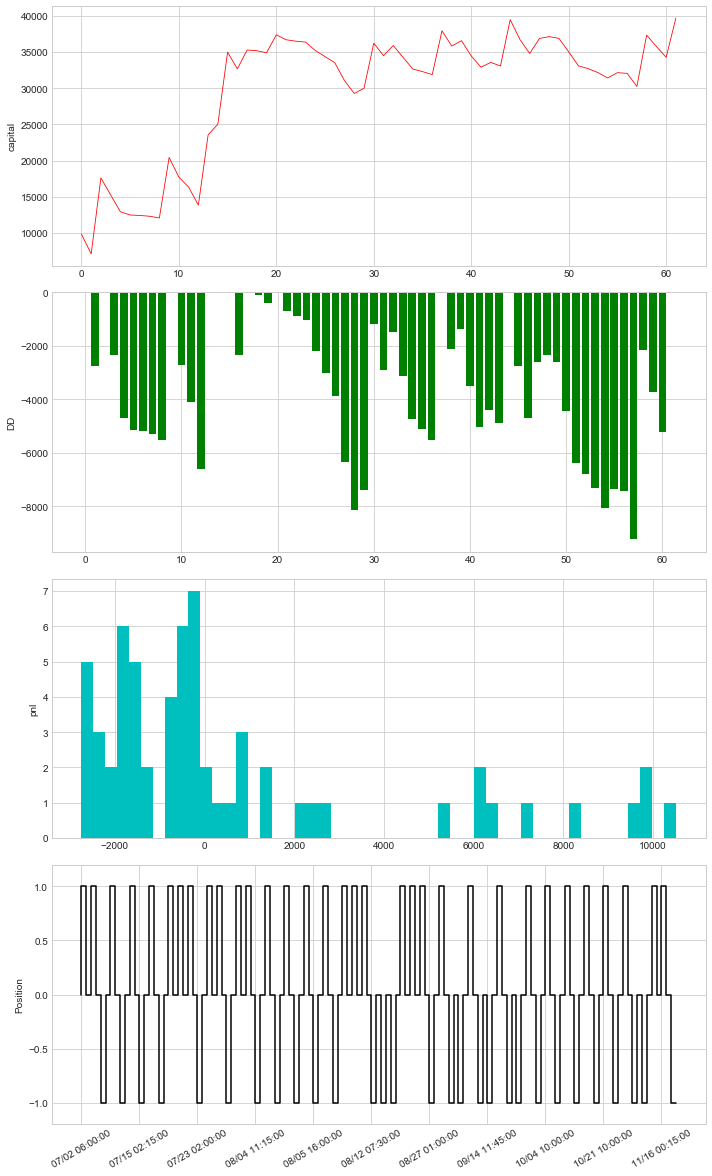

2018-12-11 20:17:09.243180	计算按日统计结果


(                netPnl  slippage  commission  turnover  tradeCount  \
 date                                                                 
 2018-07-01      0.0000       0.0      0.0000       0.0           0   
 2018-07-02   7988.3905      20.0     40.6095   81219.0           1   
 2018-07-03   1840.4130      20.0     45.5870   91174.0           1   
 2018-07-04   2195.4575      20.0     44.5425   89085.0           1   
 2018-07-05  -1807.0000       0.0      0.0000       0.0           0   
 2018-07-06  -3130.2355      20.0     43.2355   86471.0           1   
 2018-07-07      0.0000       0.0      0.0000       0.0           0   
 2018-07-08      0.0000       0.0      0.0000       0.0           0   
 2018-07-09   -296.9085      20.0     42.9085   85817.0           1   
 2018-07-10  10803.4050      20.0     37.5950   75190.0           1   
 2018-07-11  -2354.1920      40.0     72.1920  144384.0           2   
 2018-07-12      0.0000       0.0      0.0000       0.0           0   
 2018-

In [6]:
parameterDict = {'symbolList':['EOSUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180701 12:00', '20181121 12:00', 0.002, 5/10000)